In [6]:
import sys
print(sys.version)


3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]


In [1]:
import tensorflow as tf
print(tf.__version__)



2.15.0


In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [21]:
ticker = "AAPL"
start_date = "2018-01-01"
end_date = "2024-01-01"

lookback_window = 60
epochs = 40
batch_size = 32


In [22]:
df = yf.download(ticker, start=start_date, end=end_date)

df = df[['Close', 'Volume']]
df.dropna(inplace=True)

df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,Volume
Ticker,AAPL,AAPL
Date,,
2018-01-02,40.304165,102223600
2018-01-03,40.297153,118071600
2018-01-04,40.484329,89738400
2018-01-05,40.945263,94640000
2018-01-08,40.793186,82271200


In [23]:
def simulate_sentiment(data):
    sentiment = []
    current = 0
    
    for _ in range(len(data)):
        drift = np.random.normal(0, 0.02)
        current += drift
        
        if np.random.rand() < 0.03:
            current += np.random.uniform(-0.6, 0.6)
        
        current = np.clip(current, -1, 1)
        sentiment.append(current)
    
    return sentiment

df["Sentiment"] = simulate_sentiment(df)

df.head()


Price,Close,Volume,Sentiment
Ticker,AAPL,AAPL,
Date,,,
2018-01-02,40.304165,102223600,0.009934
2018-01-03,40.297153,118071600,0.007169
2018-01-04,40.484329,89738400,0.002486
2018-01-05,40.945263,94640000,-0.002197
2018-01-08,40.793186,82271200,0.593279


In [24]:
df["Target"] = df["Close"].shift(-1)
df.dropna(inplace=True)


In [25]:
features = ["Close", "Volume", "Sentiment"]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df["Target"] = df["Target"].values


In [26]:
def create_sequences(data, target, lookback):
    X, y = [], []
    
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

X, y = create_sequences(
    scaled_df[features].values,
    scaled_df["Target"].values,
    lookback_window
)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1448, 60, 3)
y shape: (1448,)


In [27]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


In [28]:
model = Sequential()

model.add(LSTM(50, return_sequences=True,
               input_shape=(lookback_window, len(features))))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10800     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31051 (121.29 KB)
Trainable params: 31051 (121.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/40
33/33 [==============================] - 6s 62ms/step - loss: 9504.9443 - mae: 86.8133 - val_loss: 19552.6816 - val_mae: 139.4387
Epoch 2/40
33/33 [==============================] - 1s 33ms/step - loss: 8527.0244 - mae: 81.0627 - val_loss: 18785.8613 - val_mae: 136.6613
Epoch 3/40
33/33 [==============================] - 1s 35ms/step - loss: 8174.4028 - mae: 78.8695 - val_loss: 18268.2363 - val_mae: 134.7542
Epoch 4/40
33/33 [==============================] - 1s 36ms/step - loss: 7888.6025 - mae: 77.0397 - val_loss: 17789.5508 - val_mae: 132.9662
Epoch 5/40
33/33 [==============================] - 1s 34ms/step - loss: 7625.2310 - mae: 75.2610 - val_loss: 17336.9219 - val_mae: 131.2531
Epoch 6/40
33/33 [==============================] - 1s 33ms/step - loss: 7375.5112 - mae: 73.5923 - val_loss: 16901.8789 - val_mae: 129.5853
Epoch 7/40
33/33 [==============================] - 1s 34ms/step - loss: 7122.8198 - mae: 71.9133 - val_loss: 16482.4062 - val_mae: 127.9565
Epoch 8/40
33

In [30]:
pred_scaled = model.predict(X_test)


10/10 [==============================] - 1s 12ms/step


In [31]:
close_index = features.index("Close")

def inverse_close(predictions):
    temp = np.zeros((len(predictions), len(features)))
    temp[:, close_index] = predictions.flatten()
    return scaler.inverse_transform(temp)[:, close_index]

y_pred = inverse_close(pred_scaled)
y_true = inverse_close(y_test.reshape(-1, 1))


In [32]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


RMSE: 17087.94713311437
MAE: 16793.187501309854
R2: -28.23840634403284


In [33]:
direction_true = np.sign(np.diff(y_true))
direction_pred = np.sign(np.diff(y_pred))

directional_accuracy = np.mean(direction_true == direction_pred) * 100

print("Directional Accuracy:", directional_accuracy)


Directional Accuracy: 8.996539792387544


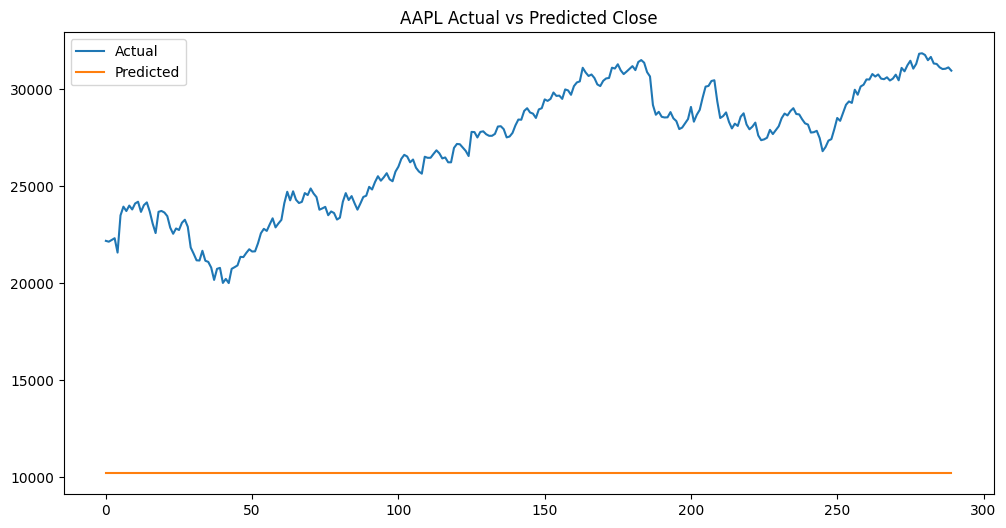

In [34]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title(f"{ticker} Actual vs Predicted Close")
plt.show()


In [35]:
last_sequence = X[-1].reshape(1, lookback_window, len(features))
next_day_scaled = model.predict(last_sequence)
next_day_price = inverse_close(next_day_scaled)

print("Predicted Next Day Close:", next_day_price[0])


1/1 [==============================] - 0s 134ms/step
Predicted Next Day Close: 10194.796639339038


In [36]:
y_true
y_pred
next_day_price


array([10194.79663934])

In [38]:
def highlight_last_row(row):
    if row.name == len(results_df) - 1:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)

results_df.style.apply(highlight_last_row, axis=1)


,Date,Actual Close,Predicted Close
0,2022-11-02 00:00:00,22182.184938,10194.795401
1,2022-11-03 00:00:00,22139.047905,10194.794782
2,2022-11-04 00:00:00,22225.314540,10194.794782
3,2022-11-07 00:00:00,22317.963317,10194.795401
4,2022-11-08 00:00:00,21578.348210,10194.794782
5,2022-11-09 00:00:00,23495.273928,10194.794782
6,2022-11-10 00:00:00,23947.348444,10194.794782
7,2022-11-11 00:00:00,23720.511251,10194.795401
8,2022-11-14 00:00:00,24001.659795,10194.795401
9,2022-11-15 00:00:00,23801.983232,10194.794782


In [39]:
# ==============================
# CREATE RESULTS TABLE
# ==============================

# Get test dates aligned with y_true
test_dates = df.index[-len(y_true):]

results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Close": y_true,
    "Predicted Close": y_pred
})

# Add next day prediction
next_date = results_df["Date"].iloc[-1] + pd.Timedelta(days=1)

next_row = pd.DataFrame({
    "Date": [next_date],
    "Actual Close": [np.nan],
    "Predicted Close": [next_day_price[0]]
})

results_df = pd.concat([results_df, next_row], ignore_index=True)

results_df.tail()


,Date,Actual Close,Predicted Close
286,2023-12-22,31044.593907,10194.795401
287,2023-12-26,31060.654514,10194.795401
288,2023-12-27,31129.728746,10194.795401
289,2023-12-28,30961.066366,10194.795401
290,2023-12-29,NaN,10194.796639


In [40]:
# ==============================
# FIX DATE ALIGNMENT
# ==============================

# Correct test date index alignment
test_start_index = lookback + train_size
test_end_index = test_start_index + len(y_true)

aligned_dates = df.index[test_start_index:test_end_index]

results_df = pd.DataFrame({
    "Date": aligned_dates,
    "Actual Close": y_true.flatten(),
    "Predicted Close": y_pred.flatten()
}).reset_index(drop=True)

results_df.head()


,Date,Actual Close,Predicted Close
0,2022-11-02,22182.184938,10194.795401
1,2022-11-03,22139.047905,10194.794782
2,2022-11-04,22225.314540,10194.794782
3,2022-11-07,22317.963317,10194.795401
4,2022-11-08,21578.348210,10194.794782


In [41]:
results_df["Error"] = results_df["Actual Close"] - results_df["Predicted Close"]
results_df["Absolute Error"] = results_df["Error"].abs()

results_df.tail()


,Date,Actual Close,Predicted Close,Error,Absolute Error
285,2023-12-21,31132.948297,10194.795401,20938.152896,20938.152896
286,2023-12-22,31044.593907,10194.795401,20849.798505,20849.798505
287,2023-12-26,31060.654514,10194.795401,20865.859113,20865.859113
288,2023-12-27,31129.728746,10194.795401,20934.933345,20934.933345
289,2023-12-28,30961.066366,10194.795401,20766.270965,20766.270965


In [42]:
next_date = results_df["Date"].iloc[-1] + pd.Timedelta(days=1)

next_row = pd.DataFrame({
    "Date": [next_date],
    "Actual Close": [np.nan],
    "Predicted Close": [next_day_price[0]],
    "Error": [np.nan],
    "Absolute Error": [np.nan]
})

results_df = pd.concat([results_df, next_row], ignore_index=True)

results_df.tail()


,Date,Actual Close,Predicted Close,Error,Absolute Error
286,2023-12-22,31044.593907,10194.795401,20849.798505,20849.798505
287,2023-12-26,31060.654514,10194.795401,20865.859113,20865.859113
288,2023-12-27,31129.728746,10194.795401,20934.933345,20934.933345
289,2023-12-28,30961.066366,10194.795401,20766.270965,20766.270965
290,2023-12-29,NaN,10194.796639,NaN,NaN
